In [1]:
%%capture
!{sys.executable} -m pip install openai
!{sys.executable} -m pip install litellm

In [1]:
import os, sys
from openai import OpenAI

if not os.environ["OPENAI_API_KEY"]: 
    os.environ["OPENAI_API_KEY"]= '<REDACTED>'

MODEL = "gpt-4o-mini"

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

Baseline decision tree:

In [2]:
class Node:
    def __init__(self, question=None, tag = None, yes_branch=None, no_branch=None, examples=None, summary=None):
        self.question = question
        self.yes_branch = yes_branch
        self.no_branch = no_branch
        self.examples = examples
        self.summary = summary
        self.tag = tag

def print_tree(node, indent=0):
    """ Recursively print the decision tree. """
    if node is None:
        return
    if node.summary:
        # Print leaf node summary
        print(' ' * indent + f'→ Summary: The keyword is {node.summary}.')
    if node.examples:
        # Print leaf node examples
        print(' ' * indent + f'→ Examples: {", ".join(node.examples)}')
    if node.question:
        # Print the question node
        turn = indent // 4 + 1
        print(' ' * indent + f'Turn {turn}: {node.question}')
        if node.yes_branch or node.no_branch:
            print(' ' * indent + ' ├─ Yes:')
            print_tree(node.yes_branch, indent + 4)  # Print yes branch
            print(' ' * indent + ' └─ No:')
            print_tree(node.no_branch, indent + 4)   # Print no branch

# Define the decision tree structure
tree = Node(
    "Is it a place?",
    tag = "place",
    yes_branch=Node(
        examples=['Lesotho', 'Acapulco', 'Oceania', 'Parking lot'],
        question="Is it a country?",
        tag = "country",
        yes_branch=Node(
            examples=['Brazil', 'Japan', 'Kenya', 'Norway'],
            question="Is this country either in Asia or in Africa?",
            yes_branch=Node(
                examples=['Thailand', 'North Korea', 'Egypt', 'Nigeria'],
                question="Is this country in Asia?",
                yes_branch=Node(summary='a country in Asia', examples=['Kazakhstan', 'South Korea']),
                no_branch=Node(summary='a country in Africa', examples=['Morocco', 'Ghana'])
            ),
            no_branch=Node(
                examples=['Lithuania', 'Papua New Guinea', 'Uruguay', 'Slovakia'],
                question="Is this country in Europe?",
                yes_branch=Node(summary='a country in Europe', examples=['Romania', 'Germany']),
                no_branch=Node(
                    examples=['Australia', 'Nicaragua', 'Chile', 'United States'],
                    question="Is this country in the Americas?",
                    yes_branch=Node(summary='a country in the Americas', examples=['Argentina', 'Canada']),
                    no_branch=Node(summary='a country in Oceania', examples=['New Zealand', 'Samoa'])
                )
            )
        ),
        no_branch=Node(
            examples=['Venice', 'Lagos', 'Times Square', 'Colosseum'],
            question="Is it a city?",
            tag = "city",
            yes_branch=Node(
                examples=['Paris', 'Astana', 'Alexandria', 'Sao Paulo'],
                question="Is it a capital city?",
                yes_branch=Node(summary='a capital city', examples=['Moscow', 'Santiago']),
                no_branch=Node(summary='a city which is not a capital', examples=['Chicago', 'Tianjin'])
            ),
            no_branch=Node(
                examples=['Oceania', 'Nevada', 'Times Square', 'Colosseum'],
                question="Is it either a continent or a state of a country?",
                yes_branch=Node(
                    examples=['North America', 'Nevada', 'Roraima', 'Uttar Pradesh'],
                    question="Is it a continent?",
                    yes_branch=Node(summary='a continent', examples=['Africa', 'Asia']),
                    no_branch=Node(summary='a state of a country', examples=['Kentucky', 'Santa Catarina Brazil'])
                ),
                no_branch=Node(
                    examples=['Copacabana beach', 'university campus', 'Antarctica', 'tundra'],
                    question="Is it a location made by humans?",
                    yes_branch=Node(summary='a location made by humans', examples=['Champs-Elysees', 'Amusement park']),
                    no_branch=Node(summary='a natural location', examples=['Amazon rainforest', 'Desert'])
                )
            )
        )
    ),
    no_branch=Node(
        examples=['Pencil sharpener', 'cloud', 'chimney', 'electric vehicle'],
        question="Is it man-made?",
        tag="man-made",
        yes_branch=Node(
            examples=['plastic bottle', 'martini', 'earbuds', 'helicopter'],
            question="Is it found indoors?",
            tag="indoors",
            yes_branch=Node(
                examples=['pencil sharpener', 'refrigerator', 'coffee machine', 'escalator'],
                question="Is it something found in a home?",
                tag="home",
                yes_branch=Node(summary='a man-made thing found in people\'s homes', examples=["Bed frame", "Stove"]),
                no_branch=Node(summary='a man-made thing found indoors but not in people\'s homes', examples=["Hospital bed", "Erlenmeyer flask"])
            ),
            no_branch=Node(
                examples=['pickup truck', 'train', 'fountain', 'obelisk'],
                question="Is it something found in a city?",
                tag="city",
                yes_branch=Node(summary='a man-made thing found outdoors in cities', examples=['Apartment Building', 'Fire Hydrant']),
                no_branch=Node(summary='a man-made thing found outdoors outside of cities', examples=['Satellite', 'Barn'])
            ),
        ),
        no_branch=Node(
            examples=['thunder', 'Acacia', 'giraffe', 'river'],
            question="Is it a living thing?",
            tag="living",
            yes_branch=Node(
                examples=['Palm tree', 'beetle', 'whale', 'apple'],
                question="Is it an animal?",
                tag="animal",
                yes_branch=Node(
                    examples=['sea lion', 'cape toad', 'kangaroo', 'peacock'],
                    question="Is it a mammal or a bird?",
                    yes_branch=Node(summary='either a mammal or a bird', examples=["Elephant", "Seagull"]),
                    no_branch=Node(summary='either a fish, insect, reptilian or amphibian', examples=["Shark", "Wasp", "Frog", "Alligator"])
                ),
                no_branch=Node(
                    examples=['mold', 'deciduous tree', 'yeast', 'agave'],
                    question="Is it a plant?",
                    tag="plant",
                    yes_branch=Node(
                        examples=['orchid', 'poison ivy', 'maple tree', 'sunflower'],
                        question="Is it a tree?",
                        yes_branch=Node(summary='a tree', examples=["Oak tree", "Cactus"]),
                        no_branch=Node(summary='a plant which is not a tree', examples=["Rose", "Fern"])
                    ),
                    no_branch=Node(
                        examples=['black mold', 'truffle', 'cremini mushroom', 'bacillus'],
                        question="Is it a fungus?",
                        yes_branch=Node(summary='a fungus', examples=["Wood ear mushroom", "Yeast"]),
                        no_branch=Node(summary='a bacteria', examples=['E Coli', 'Streptococcus'])
                    )
                )
            ),
            no_branch=Node(
                examples=['uranus', 'seine river', 'carbon', 'electron'],
                question="Is it a geological feature?",
                tag="geological feature",
                yes_branch=Node(
                    examples=['Mount Fuji', 'volcano', 'canyon', 'Rocky mountains'],
                    question="Is it a body of water?",
                    yes_branch=Node(summary='a body of water', examples=["River", "Mediterranean Sea"]),
                    no_branch=Node(summary='a geological feature which is not a body of water', examples=["Cave", "Volcano"])
                ),
                no_branch=Node(
                    examples=['mercury', 'sun', 'iron', 'lead'],
                    question="Is it a chemical element, molecule or compound?",
                    yes_branch=Node(summary='a chemical element, molecule or compound', examples=["Salt", "Oxygen"]),
                    no_branch=Node(summary='a non-living thing not made by humans', examples=['Pebble', 'Milky Way'])
                )
            )
        )
    )
)

# Print the decision tree
print_tree(tree)

Turn 1: Is it a place?
 ├─ Yes:
    → Examples: Lesotho, Acapulco, Oceania, Parking lot
    Turn 2: Is it a country?
     ├─ Yes:
        → Examples: Brazil, Japan, Kenya, Norway
        Turn 3: Is this country either in Asia or in Africa?
         ├─ Yes:
            → Examples: Thailand, North Korea, Egypt, Nigeria
            Turn 4: Is this country in Asia?
             ├─ Yes:
                → Summary: The keyword is a country in Asia.
                → Examples: Kazakhstan, South Korea
             └─ No:
                → Summary: The keyword is a country in Africa.
                → Examples: Morocco, Ghana
         └─ No:
            → Examples: Lithuania, Papua New Guinea, Uruguay, Slovakia
            Turn 4: Is this country in Europe?
             ├─ Yes:
                → Summary: The keyword is a country in Europe.
                → Examples: Romania, Germany
             └─ No:
                → Examples: Australia, Nicaragua, Chile, United States
                Turn 5

Open keywords data:

In [3]:
def read_file_to_list(file_path):
    with open(file_path, 'r') as file:
        lines = file.read().splitlines()
    return lines

keywords_list = read_file_to_list('20qs-data/keywords.txt')
keywords_list = keywords_list[1:]
print(f"Number of keywords in data: {len(keywords_list)}")

Number of keywords in data: 2046


## Label Data

Functions to all Open AI API for labeling data:

In [15]:
from collections import Counter
from tqdm import tqdm
import time

def get_answer_from_node(node, keyword):
    
    prompt = f"Keyword: {keyword}\n\nQuestion: {node.question}\n\n"
    prompt += "\nPlease provide an answer to the question based on the keyword. ONLY ANSWER Yes OR No. IF UNSURE, CHOOSE MOST LIKELY ANSWER FROM Yes OR No. "
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": prompt}
        ],
        max_tokens=10
    )
    response = response.choices[0].message.content

    return response


def label_keywords(node, keywords, labels, results):
    
    question_tag = node.tag
    yes_no_counts = Counter()

    for keyword in tqdm(keywords, desc = 'label_keywords', position = 0, leave = True, ncols = 100):
        answer = get_answer_from_node(node, keyword)
        answer = answer.lower()
        # Count yes/no answers
        if 'yes' in answer:
            yes_no_counts['yes'] += 1
            answer = 'yes'
        elif 'no' in answer:
            yes_no_counts['no'] += 1
            answer = 'no'
        else:
            yes_no_counts['err'] +=1
            answer = 'err'
        if keyword in labels:
            labels[keyword][question_tag] = answer
        else:
            labels[keyword] = {question_tag: answer}

    # Calculate percentages
    total_answers = sum(yes_no_counts.values())
    yes_percentage = (yes_no_counts['yes'] / total_answers) * 100 if total_answers > 0 else 0
    no_percentage = (yes_no_counts['no'] / total_answers) * 100 if total_answers > 0 else 0
    err_percentage = (yes_no_counts['err'] / total_answers) * 100 if total_answers > 0 else 0

    # Print results
    print(node.question)
    print(f"Yes answers: {yes_no_counts['yes']}, percentage: {yes_percentage:.2f}%")
    print(f"No answers: {yes_no_counts['no']}, percentage: {no_percentage:.2f}%")
    print(f"Error answers: {yes_no_counts['err']}, percentage: {err_percentage:.2f}%")

    # Save results
    results[question_tag] = {
        'yes_percentage': yes_percentage,
        'no_percentage': no_percentage,
        'value_counts': dict(yes_no_counts)
    }

    return labels, results

Read current keyword labels and results:

In [4]:
import json

def read_jsonl_and_transform(file_path):
    result_dict = {}

    with open(file_path, 'r') as file:
        for line in file:
            record = json.loads(line)
            keyword = record.pop('keyword')
            result_dict[keyword] = record

    return result_dict

def read_json_to_dict(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

keyword_labels, results = read_jsonl_and_transform('20qs-data/labeled_keywords.jsonl'), read_json_to_dict('20qs-data/labeling_results.jsonl')

Label places/things:

In [72]:
keyword_labels, results = label_keywords(tree, keywords_list, keyword_labels, results)

Is it a place?
Yes answers: 719, percentage: 35.15892420537897%
No answers: 1326, percentage: 64.84107579462103%
Error answers: 0, percentage: 0.0%


In [5]:
keyword_places = [keyword for keyword in keywords_list if keyword_labels[keyword]['place'] == 'yes']
keyword_things = [keyword for keyword in keywords_list if keyword_labels[keyword]['place'] == 'no']
things_branch = tree.no_branch
places_branch = tree.yes_branch

print(f"Number of keywords labeled as things: {len(keyword_things)}.")

Number of keywords labeled as things: 1327.


Label man-made living:

In [100]:
keyword_labels, results = label_keywords(not_man_made_branch, keyword_not_man_made, keyword_labels, results)

Is it a living thing?
Yes answers: 182, percentage: 64.31095406360424%
No answers: 101, percentage: 35.68904593639576%
Error answers: 0, percentage: 0.0%


In [104]:
living_branch = not_man_made_branch.yes_branch
not_living_branch = not_man_made_branch.no_branch

Label indoors:

In [110]:
keyword_labels, results = label_keywords(man_made_branch, keyword_man_made, keyword_labels, results)

Is it found indoors?
Yes answers: 912, percentage: 87.44%
No answers: 131, percentage: 12.56%
Error answers: 0, percentage: 0.00%


In [111]:
keyword_indoors = [keyword for keyword in keyword_man_made if keyword_labels[keyword]['indoors'] == 'yes']
keyword_outdoors = [keyword for keyword in keyword_man_made if keyword_labels[keyword]['indoors'] == 'no']

Categorical labels:

In [10]:
category_nodes = [
    Node(question='Is it broadly related to food, drinks or cooking?', tag='food, drinks, cooking'),
    Node(question='Is it broadly related to arts, sports or entertainment?', tag='arts, sports, entertainment'),
    Node(question='Is it broadly related to clothing, beauty or accessories?', tag='clothing, beauty, accessories'),
    Node(question='Is it broadly related to furniture or architecture?', tag='furniture, architecture'),
    Node(question='Is it broadly related to cleaning or hygiene?', tag='cleaning, hygiene'),
    Node(question='Is it broadly related to transportation or vehicles?', tag='transportation, vehicles'),
    Node(question='Is it broadly related to electronics or technology?', tag='electronics, technology'),    
    Node(question='Is it broadly related to agriculture or industry?', tag='agriculture, industry'),
    Node(question='Is it related to science or education?', tag='science, school, education'),
    Node(question='Is it related to health or safety?', tag='health, safety'),
]

In [ ]:
for cat_node in tqdm(category_nodes, desc = 'categories', ncols=150):
    keyword_labels, results = label_keywords(cat_node, keyword_things, keyword_labels, results)

In [11]:
keyword_labels, results = label_keywords(category_nodes[-2], keyword_things, keyword_labels, results)

label_keywords: 100%|███████████████████████████████████████████| 1327/1327 [11:24<00:00,  1.94it/s]

Is it related to science or education?
Yes answers: 470, percentage: 35.42%
No answers: 857, percentage: 64.58%
Error answers: 0, percentage: 0.00%


In [13]:
living_branch = tree.no_branch.no_branch
indoors_branch = tree.no_branch.yes_branch
print(living_branch.question, living_branch.tag)
print(indoors_branch.question, indoors_branch.tag)

Is it a living thing? living
Is it found indoors? indoors


In [ ]:
keyword_labels, results = label_keywords(living_branch, keyword_things, keyword_labels, results)
keyword_labels, results = label_keywords(indoors_branch, keyword_things, keyword_labels, results)

## Categorical Labels Analysis

In [6]:
%%capture
!pip install --upgrade upsetplot matplotlib seaborn

In [7]:
import pandas as pd
import numpy as np

def make_list_from_dict(original_dict):
    list_of_dicts = []
    for key, sub_dict in original_dict.items():
        if sub_dict['place'] == 'yes':
            continue
        # Create a new dictionary that includes the key from the original dict
        new_dict = {"keyword": key}
        # Update the new dictionary with the key-value pairs from the sub-dictionary
        new_dict.update(sub_dict)
        # Append the new dictionary to the list
        list_of_dicts.append(new_dict)
    return list_of_dicts

labeled_things_list = make_list_from_dict(keyword_labels)

things_df =  pd.DataFrame(labeled_things_list)


In [8]:
things_df.set_index('keyword', inplace = True)
things_df.drop(columns = ['indoors', 'place'], inplace = True)
things_df = things_df.replace({'yes': 1, 'no': 0})
things_df.head(10)

,man-made,"food, drinks, cooking","arts, sports, entertainment","clothing, beauty, accessories","furniture, architecture","cleaning, hygiene","transportation, vehicles","electronics, technology","agriculture, industry","health, safety",living,"science, education"
keyword,,,,,,,,,,,,
acacia,0,1,0,0,1,0,0,0,1,0,1,1
accent chair,1,0,0,0,1,0,0,0,0,0,0,0
acorn,0,1,0,0,0,0,0,0,1,0,0,0
adhd medication,1,0,0,0,0,0,0,0,0,1,0,1
adjustable bench,1,0,0,0,1,0,0,0,0,1,0,0
Advertisement,1,1,1,1,1,1,0,1,0,0,0,0
aerator,1,1,0,0,0,0,0,0,1,0,0,0
Agave,0,1,0,0,0,0,0,0,1,0,1,1
agave plant,0,1,0,0,0,0,0,0,1,0,1,1


In [9]:
has_nan = things_df.isna().any().any()
print(has_nan)

False


In [10]:
things_df.describe()

,man-made,"food, drinks, cooking","arts, sports, entertainment","clothing, beauty, accessories","furniture, architecture","cleaning, hygiene","transportation, vehicles","electronics, technology","agriculture, industry","health, safety",living,"science, education"
count,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000
mean,0.785983,0.296157,0.180859,0.163527,0.130369,0.222306,0.071590,0.232102,0.316503,0.232856,0.122833,0.228335
std,0.410293,0.456733,0.385046,0.369985,0.336836,0.415952,0.257905,0.422333,0.465287,0.422811,0.328370,0.419918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Figure size 5000x3000 with 0 Axes>

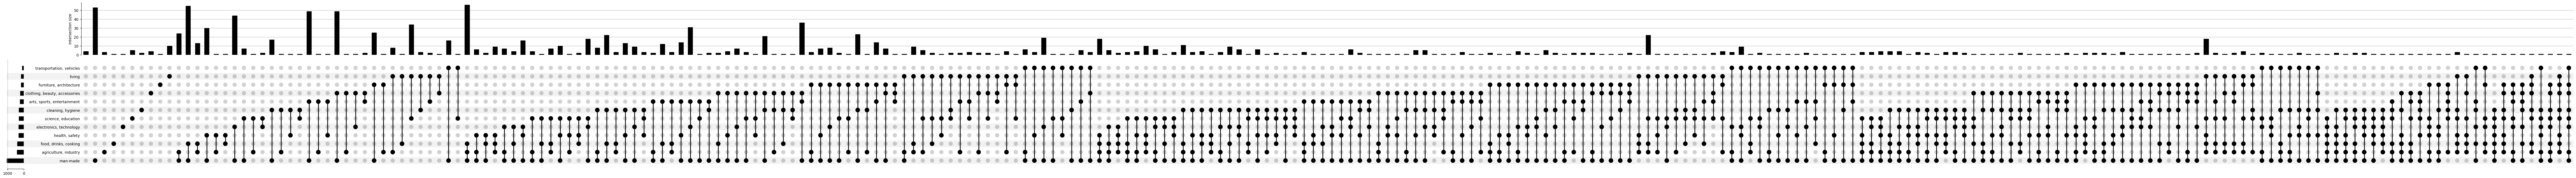

In [11]:
from matplotlib import pyplot as plt
from upsetplot import UpSet, from_memberships

def create_upset_plot(df, figsize=(50, 30)):
    # Step 1: Aggregate duplicate rows
    grouped_df = df.groupby(list(df.columns)).size().reset_index(name='counts')
    
    # Step 2: Create a list of memberships (feature combinations) and their counts
    memberships = []
    counts = []
    for row in grouped_df.itertuples(index=False):
        combination = [col for col, val in zip(grouped_df.columns[:-1], row[:-1]) if val]
        memberships.append(combination)
        counts.append(row.counts)
    
    # Step 3: Convert to UpSet format
    upset_data = from_memberships(memberships, data=counts)
    
    # Step 4: Create and plot the UpSet plot
    plt.figure(figsize = figsize)
    upset = UpSet(upset_data)
    upset.plot()
    plt.show()
    
create_upset_plot(things_df)

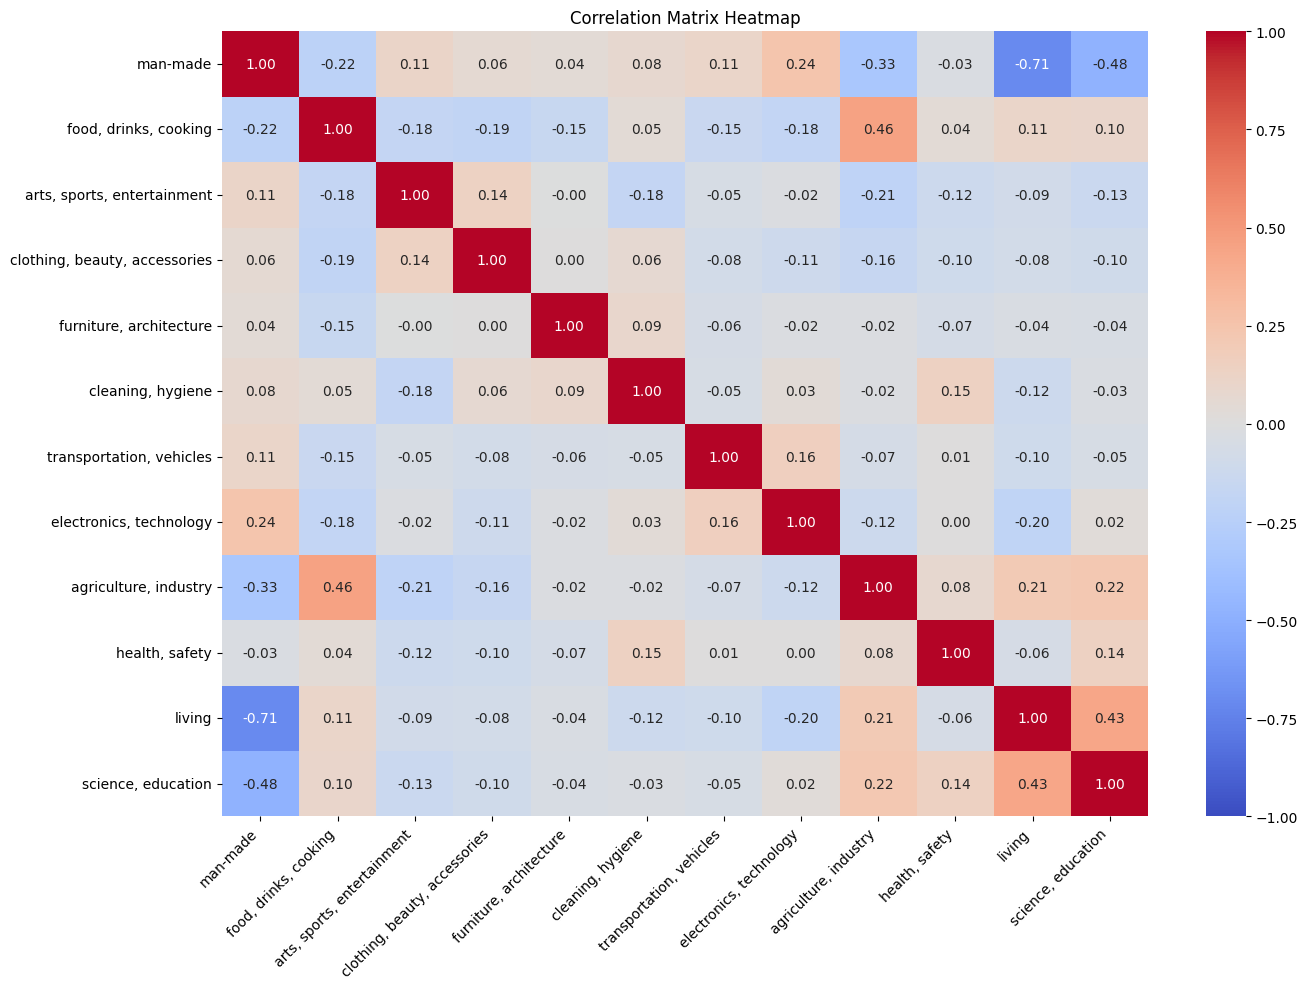

In [12]:
import seaborn as sns

corr_matrix = things_df.corr()

# Step 3: Create a Heatmap of the Correlation Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0, annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Rotate y-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

## Optimal Game Path with Monte Carlo Simulations

In [62]:
import math
from tqdm import tqdm

class MonteCarloNode:
    def __init__(self, queries, answers, depth, size, data_size, yes_branch = None, no_branch = None):
        self.queries = queries
        self.answers = answers
        self.depth = depth
        self.size = size
        self.data_size = data_size
        self.yes_branch = yes_branch
        self.no_branch = no_branch
    
    def getCurrentData(self, data):
        curr_data = data
        for (query, answer) in zip(self.queries, self.answers):
            curr_data = curr_data[curr_data[query] == answer]
        return curr_data
    
    def isTerminal(self, data, min_percent_reduction = 0.15, max_percent_subset = 0.05):
        queries_left = [query for query in data.columns if query not in self.queries]
        if not queries_left:
            print(f"Terminal leaf at depth {self.depth}. No queries left.")
        curr_data = self.getCurrentData(data)
        if curr_data.empty or len(curr_data) < max_percent_subset * len(data):
            print(f"Terminal leaf at depth {self.depth}. Min subset size reached.")
            return True
        for query in queries_left:
            yes_data = curr_data[curr_data[query] == 1]
            no_data = curr_data[curr_data[query] == 0]
            if yes_data.empty or no_data.empty: continue
            reduction_size = min(len(yes_data), len(no_data))
            if reduction_size > min_percent_reduction*len(curr_data):
                return False
        print(f"Terminal leaf at depth {self.depth}. No significant queries left.")
        return True
    
    def MonteCarloSimulation(self, data, n_iter, min_percent_reduction = 0.15, max_percent_subset = 0.05):
        queries_left = [query for query in data.columns if query not in self.queries]
        start_data = self.getCurrentData(data)
        queries_count = {query: 0 for query in queries_left}
        queries_total_gain = {query: 0 for query in queries_left}
        
        for _ in tqdm(range(n_iter*len(start_data)), desc = f'MC simulation at node of depth {self.depth}'):
            curr_data = start_data
            row = start_data.sample(1).iloc[0]
            random_queries = list(np.random.permutation(queries_left))
            start = True
            n_turns = 0
            
            while random_queries:
                curr_query = random_queries.pop()
                next_data = curr_data[curr_data[curr_query] == row[curr_query]]
                next_data_complement = curr_data[curr_data[curr_query] != row[curr_query]] 
                if next_data.empty or next_data_complement.empty:
                    continue
                reduction_size = min(len(next_data), len(next_data_complement))
                if reduction_size < min_percent_reduction*len(curr_data): 
                    continue
                curr_data = next_data
                if start: 
                    first_query = curr_query
                    start = False
                n_turns += 1
                if curr_data.empty or len(curr_data) < max_percent_subset*self.data_size:
                    break
            
            if n_turns > 0:
                information_gain = - math.log2(len(curr_data)/len(start_data))/n_turns if not curr_data.empty else - math.log2(max_percent_subset*self.data_size/len(start_data))/n_turns
                queries_count[first_query] += 1
                queries_total_gain[first_query] += information_gain
        
        queries_avg_gain = sorted([(query, queries_total_gain[query]/queries_count[query]) for query in queries_left if queries_count[query] > 0],
                                  key = lambda x: x[1],
                                  reverse = True)
        if queries_avg_gain == []:
            return None
        else:
            #print("Top 3 queries:")
            #for i in range(min(3, len(queries_avg_gain))):
            #    query, avg_gain = queries_avg_gain[i]
            #    print(f"Query: {query}. Average information gain: {avg_gain:.2f}")
            return queries_avg_gain[0][0]
    
    def addChildNodes(self, data, n_iter, min_percent_reduction = 0.15, max_percent_subset = 0.05):
        if self.isTerminal(data, min_percent_reduction = 0.15, max_percent_subset = 0.05):
            return 1
        curr_data = self.getCurrentData(data)
        next_query = self.MonteCarloSimulation(data, n_iter=n_iter, min_percent_reduction=min_percent_reduction, max_percent_subset=max_percent_subset)
        if next_query == None: 
            print(f"Terminal leaf at depth {self.depth}. No significant queries left.")
            return 1
        len_yes_data = len(curr_data[curr_data[next_query] == 1]) if not curr_data[curr_data[next_query] == 1].empty else 0
        len_no_data = len(curr_data[curr_data[next_query] == 0]) if not curr_data[curr_data[next_query] == 0].empty else 0
        yes_branch = MonteCarloNode(queries = self.queries + [next_query], answers = self.answers + [1], depth = self.depth+1, size = len_yes_data, data_size = self.data_size)
        no_branch = MonteCarloNode(queries = self.queries + [next_query], answers = self.answers + [0], depth = self.depth+1, size = len_no_data, data_size = self.data_size)
        print(f"Added branches at depth {self.depth+1} with sizes {len_yes_data}, {len_no_data}. Query: {next_query}.")
        self.yes_branch = yes_branch
        self.no_branch = no_branch
        return 0
    
    def buildDecisionTree(self, data, n_iter, min_percent_reduction = 0.15, max_percent_subset = 0.05):
        terminal = self.addChildNodes(data = data, n_iter=n_iter, min_percent_reduction=min_percent_reduction, max_percent_subset=max_percent_subset)
        if terminal:
            return
        else: 
            self.yes_branch.buildDecisionTree(data = data, n_iter=n_iter, min_percent_reduction=min_percent_reduction, max_percent_subset=max_percent_subset)
            self.no_branch.buildDecisionTree(data = data, n_iter=n_iter, min_percent_reduction=min_percent_reduction, max_percent_subset=max_percent_subset)
        return  

In [63]:
data = things_df

starting_node = MonteCarloNode(queries=[], answers=[], depth = 0, size = len(data), data_size = len(data))
first_query = starting_node.buildDecisionTree(data = data, n_iter = 100, min_percent_reduction=0.20, max_percent_subset=0.05)

MC simulation at node of depth 0:   0%|          | 0/132700 [00:00<?, ?it/s]

MC simulation at node of depth 0: 100%|██████████| 132700/132700 [1:01:03<00:00, 36.22it/s] 


Added branches at depth 1 with sizes 393, 934. Query: food, drinks, cooking.


MC simulation at node of depth 1: 100%|██████████| 39300/39300 [07:25<00:00, 88.26it/s] 


Added branches at depth 2 with sizes 254, 139. Query: agriculture, industry.


MC simulation at node of depth 2: 100%|██████████| 25400/25400 [02:54<00:00, 145.25it/s]


Added branches at depth 3 with sizes 65, 189. Query: living.
Terminal leaf at depth 3. Min subset size reached.


MC simulation at node of depth 3: 100%|██████████| 18900/18900 [01:34<00:00, 199.16it/s]


Added branches at depth 4 with sizes 46, 143. Query: science, education.
Terminal leaf at depth 4. Min subset size reached.


MC simulation at node of depth 4: 100%|██████████| 14300/14300 [01:13<00:00, 195.32it/s]


Added branches at depth 5 with sizes 111, 32. Query: man-made.


MC simulation at node of depth 5: 100%|██████████| 11100/11100 [00:56<00:00, 196.54it/s]


Added branches at depth 6 with sizes 25, 86. Query: health, safety.
Terminal leaf at depth 6. Min subset size reached.


MC simulation at node of depth 6: 100%|██████████| 8600/8600 [00:38<00:00, 220.68it/s]


Added branches at depth 7 with sizes 19, 67. Query: cleaning, hygiene.
Terminal leaf at depth 7. Min subset size reached.
Terminal leaf at depth 7. No significant queries left.
Terminal leaf at depth 5. Min subset size reached.


MC simulation at node of depth 2: 100%|██████████| 13900/13900 [01:33<00:00, 148.75it/s]


Added branches at depth 3 with sizes 49, 90. Query: cleaning, hygiene.
Terminal leaf at depth 3. Min subset size reached.


MC simulation at node of depth 3: 100%|██████████| 9000/9000 [01:02<00:00, 144.04it/s]


Terminal leaf at depth 3. No significant queries left.


MC simulation at node of depth 1: 100%|██████████| 93400/93400 [13:41<00:00, 113.75it/s] 


Added branches at depth 2 with sizes 263, 671. Query: electronics, technology.


MC simulation at node of depth 2: 100%|██████████| 26300/26300 [02:36<00:00, 168.26it/s]


Added branches at depth 3 with sizes 63, 200. Query: science, education.
Terminal leaf at depth 3. Min subset size reached.


MC simulation at node of depth 3: 100%|██████████| 20000/20000 [01:48<00:00, 183.58it/s]


Added branches at depth 4 with sizes 40, 160. Query: arts, sports, entertainment.
Terminal leaf at depth 4. Min subset size reached.


MC simulation at node of depth 4: 100%|██████████| 16000/16000 [01:19<00:00, 201.02it/s]


Added branches at depth 5 with sizes 36, 124. Query: cleaning, hygiene.
Terminal leaf at depth 5. Min subset size reached.


MC simulation at node of depth 5: 100%|██████████| 12400/12400 [00:54<00:00, 228.29it/s]


Added branches at depth 6 with sizes 31, 93. Query: transportation, vehicles.
Terminal leaf at depth 6. Min subset size reached.


MC simulation at node of depth 6: 100%|██████████| 9300/9300 [00:36<00:00, 251.41it/s]


Added branches at depth 7 with sizes 20, 73. Query: health, safety.
Terminal leaf at depth 7. Min subset size reached.


MC simulation at node of depth 7: 100%|██████████| 7300/7300 [00:26<00:00, 277.33it/s]


Terminal leaf at depth 7. No significant queries left.


MC simulation at node of depth 2: 100%|██████████| 67100/67100 [07:28<00:00, 149.70it/s]


Added branches at depth 3 with sizes 162, 509. Query: arts, sports, entertainment.


MC simulation at node of depth 3: 100%|██████████| 16200/16200 [01:33<00:00, 173.98it/s]


Added branches at depth 4 with sizes 56, 106. Query: clothing, beauty, accessories.
Terminal leaf at depth 4. Min subset size reached.


MC simulation at node of depth 4: 100%|██████████| 10600/10600 [01:02<00:00, 170.77it/s]


Terminal leaf at depth 4. No significant queries left.


MC simulation at node of depth 3: 100%|██████████| 50900/50900 [04:46<00:00, 177.64it/s]


Added branches at depth 4 with sizes 115, 394. Query: clothing, beauty, accessories.


MC simulation at node of depth 4: 100%|██████████| 11500/11500 [01:04<00:00, 177.68it/s]


Added branches at depth 5 with sizes 34, 81. Query: cleaning, hygiene.
Terminal leaf at depth 5. Min subset size reached.
Terminal leaf at depth 5. No significant queries left.


MC simulation at node of depth 4: 100%|██████████| 39400/39400 [02:41<00:00, 244.71it/s]


Added branches at depth 5 with sizes 288, 106. Query: man-made.


MC simulation at node of depth 5: 100%|██████████| 28800/28800 [01:43<00:00, 277.62it/s]


Added branches at depth 6 with sizes 65, 223. Query: agriculture, industry.
Terminal leaf at depth 6. Min subset size reached.


MC simulation at node of depth 6: 100%|██████████| 22300/22300 [01:10<00:00, 316.91it/s]


Added branches at depth 7 with sizes 64, 159. Query: furniture, architecture.
Terminal leaf at depth 7. Min subset size reached.


MC simulation at node of depth 7: 100%|██████████| 15900/15900 [00:42<00:00, 372.01it/s]


Added branches at depth 8 with sizes 39, 120. Query: cleaning, hygiene.
Terminal leaf at depth 8. Min subset size reached.


MC simulation at node of depth 8: 100%|██████████| 12000/12000 [00:27<00:00, 442.13it/s]


Added branches at depth 9 with sizes 43, 77. Query: health, safety.
Terminal leaf at depth 9. Min subset size reached.


MC simulation at node of depth 9: 100%|██████████| 7700/7700 [00:11<00:00, 680.37it/s]


Added branches at depth 10 with sizes 17, 60. Query: transportation, vehicles.
Terminal leaf at depth 10. Min subset size reached.
Terminal leaf at depth 10. Min subset size reached.


MC simulation at node of depth 5: 100%|██████████| 10600/10600 [00:21<00:00, 488.96it/s]


Added branches at depth 6 with sizes 76, 30. Query: living.


MC simulation at node of depth 6: 100%|██████████| 7600/7600 [00:13<00:00, 581.57it/s]

Added branches at depth 7 with sizes 51, 25. Query: science, education.
Terminal leaf at depth 7. Min subset size reached.
Terminal leaf at depth 7. Min subset size reached.
Terminal leaf at depth 6. Min subset size reached.


In [69]:
def print_decision_tree(node, indent=""):
    if node is None:
        return
    
    if node.yes_branch:
        last_query = node.yes_branch.queries[-1] if isinstance(node.yes_branch.queries, list) else node.yes_branch.queries
        print(f"{indent}Yes Branch: {last_query}")
        print(f"{indent}├── Size: {node.yes_branch.size}")
        print_decision_tree(node.yes_branch, indent + "│   ")
    if node.no_branch:
        last_query = node.no_branch.queries[-1] if isinstance(node.no_branch.queries, list) else node.no_branch.queries
        print(f"{indent}No Branch: {last_query}")
        print(f"{indent}└── Size: {node.no_branch.size}")
        print_decision_tree(node.no_branch, indent + "    ")
            
print_decision_tree(starting_node)

Yes Branch: food, drinks, cooking
├── Size: 393
│   Yes Branch: agriculture, industry
│   ├── Size: 254
│   │   Yes Branch: living
│   │   ├── Size: 65
│   │   No Branch: living
│   │   └── Size: 189
│   │       Yes Branch: science, education
│   │       ├── Size: 46
│   │       No Branch: science, education
│   │       └── Size: 143
│   │           Yes Branch: man-made
│   │           ├── Size: 111
│   │           │   Yes Branch: health, safety
│   │           │   ├── Size: 25
│   │           │   No Branch: health, safety
│   │           │   └── Size: 86
│   │           │       Yes Branch: cleaning, hygiene
│   │           │       ├── Size: 19
│   │           │       No Branch: cleaning, hygiene
│   │           │       └── Size: 67
│   │           No Branch: man-made
│   │           └── Size: 32
│   No Branch: agriculture, industry
│   └── Size: 139
│       Yes Branch: cleaning, hygiene
│       ├── Size: 49
│       No Branch: cleaning, hygiene
│       └── Size: 90
No Branch: food, dri

## Save as JSONL

In [28]:
def make_list_from_dict(original_dict):
    list_of_dicts = []
    for key, sub_dict in original_dict.items():
        # Create a new dictionary that includes the key from the original dict
        new_dict = {"keyword": key}
        # Update the new dictionary with the key-value pairs from the sub-dictionary
        new_dict.update(sub_dict)
        # Append the new dictionary to the list
        list_of_dicts.append(new_dict)
    return list_of_dicts

labeled_keywords_list = make_list_from_dict(keyword_labels)

In [29]:
with open("20qs-data/labeled_keywords.jsonl", "w") as f:
    for i in labeled_keywords_list:
        json.dump(i, f)
        f.write('\n')

with open("20qs-data/labeling_results.jsonl", "w") as f:
    json.dump(results, f)